In [1]:
using Pkg
cd("D:\\Home\\Git\\Oceananigans.jl")
# cd("C:\\Users\\Ali\\Documents\\Git\\Oceananigans.jl\\")
Pkg.activate(".");

In [2]:
using Statistics, Printf, BenchmarkTools
using Oceananigans, Oceananigans.Operators

In [ ]:
Pkg.test("Oceananigans")

In [3]:
@inline incmod1(a, n) = a == n ? one(a) : a + 1
@inline decmod1(a, n) = a == 1 ? n : a - 1

function laplacian3d_ppn(f)
    Nx, Ny, Nz = size(f)
    ∇²f = zeros(Nx, Ny, Nz)
    for k in 2:(Nz-1), j in 1:Ny, i in 1:Nx
       ∇²f[i, j, k] = f[incmod1(i, Nx), j, k] + f[decmod1(i, Nx), j, k] + f[i, incmod1(j, Ny), k] + f[i, decmod1(j, Ny), k] + f[i, j, k+1] + f[i, j, k-1] - 6*f[i, j, k]
    end
    for j in 1:Ny, i in 1:Nx
        ∇²f[i, j,   1] = -(f[i, j,     1] - f[i, j,   2]) + f[incmod1(i, Nx), j,   1] + f[decmod1(i, Nx), j,   1] + f[i, incmod1(j, Ny),   1] + f[i, decmod1(j, Ny),   1] - 4*f[i, j,   1]
        ∇²f[i, j, end] =  (f[i, j, end-1] - f[i, j, end]) + f[incmod1(i, Nx), j, end] + f[decmod1(i, Nx), j, end] + f[i, incmod1(j, Ny), end] + f[i, decmod1(j, Ny), end] - 4*f[i, j, end]
    end
    ∇²f
end

laplacian3d_ppn (generic function with 1 method)

In [4]:
# Nᵗ = 18000
# Δt = 5  # Time step [s].

N = (100, 1, 100)
L = (2000, 2000, 2000)

c = EarthConstants()
eos = LinearEquationOfState()

g = RegularCartesianGrid(N, L; dim=2, FloatType=Float64)

U  = VelocityFields(g)
tr = TracerFields(g)
pr = PressureFields(g)
G  = SourceTerms(g)
Gp = SourceTerms(g)
F  = ForcingFields(g)
tmp = TemporaryFields(g);

In [5]:
U.u.data  .= 0;
U.v.data  .= 0;
U.w.data  .= 0;
tr.S.data .= 35;
tr.T.data .= 283;

In [6]:
pHY_profile = [-eos.ρ₀*c.g*h for h in g.zC]
pr.pHY.data .= repeat(reshape(pHY_profile, 1, 1, g.Nz), g.Nx, g.Ny, 1);

ρ!(eos, g, tr)

In [7]:
tr.T.data[Int(g.Nx/2)-2:Int(g.Nx/2)+2, 1, 10-2:10+2] .= 283.01;

In [17]:
function time_stepping!(g::Grid, eos::LinearEquationOfState,
                        U::VelocityFields, tr::TracerFields, pr::PressureFields, G::SourceTerms, Gp::SourceTerms, F::ForcingFields, tmp::TemporaryFields,
                        Nt, Δt, R, ΔR)
    for n in 1:Nt
        # Calculate new density and density deviation.
        δρ = tmp.fC1
        δρ!(eos, g, δρ, tr)
        @. tr.ρ.data = eos.ρ₀ + δρ.data
        
        # Calculate density at the z-faces.
        δρz = tmp.fFZ
        avgz!(g, δρ, δρz)
        
        # Calculate hydrostatic pressure anomaly (buoyancy).
        for j in 1:g.Ny, i in 1:g.Nx
          pr.pHY′.data[i, j, 1] = δρ.data[i, j, 1] * c.g * g.Δz / 2
        end
        for k in 2:g.Nz, j in 1:g.Ny, i in 1:g.Nx
          pr.pHY′.data[i, j, k] = pr.pHY′.data[i, j, k-1] + (δρz.data[i, j, k] * c.g * g.Δz)
        end
        
        # Store source terms from previous time step.
        Gp.Gu.data .= G.Gu.data
        Gp.Gv.data .= G.Gv.data
        Gp.Gw.data .= G.Gw.data
        Gp.GT.data .= G.GT.data
        Gp.GS.data .= G.GS.data

        # Calculate source terms for current time step.
        ∂xpHY′ = tmp.fFX
        δx!(g, pr.pHY′, ∂xpHY′)
        @. ∂xpHY′.data = ∂xpHY′.data / (g.Δx * eos.ρ₀)
        
        𝜈∇²u = tmp.fFY
        𝜈∇²u!(g, U.u, 𝜈∇²u, 4e-2, 4e-2, tmp)
        
        @. G.Gu.data .= - ∂xpHY′.data + 𝜈∇²u.data
        
        ∂ypHY′ = tmp.fFY
        δy!(g, pr.pHY′, ∂ypHY′)
        @. ∂ypHY′.data = ∂ypHY′.data / (g.Δy * eos.ρ₀)
        
        𝜈∇²v = tmp.fFX
        𝜈∇²v!(g, U.v, 𝜈∇²v, 4e-2, 4e-2, tmp)
        
        @. G.Gv.data .= - ∂ypHY′.data + 𝜈∇²v.data
        
        𝜈∇²w = tmp.fFZ
        𝜈∇²w!(g, U.w, 𝜈∇²w, 4e-2, 4e-2, tmp)
        
        @. G.Gw.data = 𝜈∇²w.data
        
        # ∇uT = tmp.fC1
        # div_flux!(g, U.u, U.v, U.w, tr.T, ∇uT, tmp)
        
        κ∇²T = tmp.fC4
        κ∇²!(g, tr.T, κ∇²T, 4e-2, 4e-2, tmp)

        @. G.GT.data = κ∇²T.data
        # @. G.GT.data = -∇uT.data + κ∇²T.data
        
        # ∇uS = tmp.fC1
        # div_flux!(g, U.u, U.v, U.w, tr.S, ∇uS, tmp)
        
        κ∇²S = tmp.fC4
        κ∇²!(g, tr.S, κ∇²S, 4e-2, 4e-2, tmp)
        
        @. G.GS.data = κ∇²S.data
        # @. G.GS.data = -∇uS.data + κ∇²S.data
        
        χ = 0.1  # Adams-Bashforth (AB2) parameter.
        @. G.Gu.data = (1.5 + χ)*G.Gu.data - (0.5 + χ)*Gp.Gu.data
        @. G.Gv.data = (1.5 + χ)*G.Gv.data - (0.5 + χ)*Gp.Gv.data
        @. G.Gw.data = (1.5 + χ)*G.Gw.data - (0.5 + χ)*Gp.Gw.data
        @. G.GT.data = (1.5 + χ)*G.GT.data - (0.5 + χ)*Gp.GT.data
        @. G.GS.data = (1.5 + χ)*G.GS.data - (0.5 + χ)*Gp.GS.data
        
        RHS = tmp.fCC1
        ϕ   = tmp.fCC2
        div!(g, G.Gu, G.Gv, G.Gw, RHS, tmp)
        solve_poisson_3d_ppn!(g, RHS, ϕ)
        @. pr.pNHS.data = real(ϕ.data)
        
#         div!(g, G.Gu, G.Gv, G.Gw, RHS, tmp)
#         RHSr = real.(RHS.data)
#         RHS_rec = laplacian3d_ppn(pr.pNHS.data) ./ (g.Δx)^2  # TODO: This assumes Δx == Δy == Δz.
#         error = RHS_rec .- RHSr
#         @info begin
#             string("Fourier-spectral solver diagnostics:\n",
#                     @sprintf("RHS:     min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(RHSr), maximum(RHSr), mean(RHSr), mean(abs.(RHSr)), std(RHSr)),
#                     @sprintf("RHS_rec: min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(RHS_rec), maximum(RHS_rec), mean(RHS_rec), mean(abs.(RHS_rec)), std(RHS_rec)),
#                     @sprintf("error:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(error), maximum(error), mean(error), mean(abs.(error)), std(error))
#                     )
#         end
        
        ∂xpNHS, ∂ypNHS, ∂zpNHS = tmp.fFX, tmp.fFY, tmp.fFZ
        
        δx!(g, pr.pNHS, ∂xpNHS)
        δy!(g, pr.pNHS, ∂ypNHS)
        δz!(g, pr.pNHS, ∂zpNHS)
        
        @. ∂xpNHS.data = - ∂xpNHS.data / (g.Δx * eos.ρ₀)
        @. ∂ypNHS.data = - ∂ypNHS.data / (g.Δy * eos.ρ₀)
        @. ∂zpNHS.data = - ∂zpNHS.data / (g.Δz * eos.ρ₀)
        
        @. U.u.data  = U.u.data  + (G.Gu.data - ∂xpNHS.data) * Δt
        @. U.v.data  = U.v.data  + (G.Gv.data - ∂ypNHS.data) * Δt
        @. U.v.data  = U.v.data  + (G.Gw.data - ∂zpNHS.data) * Δt
        @. tr.T.data = tr.T.data + (G.GT.data * Δt)
        @. tr.S.data = tr.S.data + (G.GS.data * Δt)
        
        div_u1 = tmp.fC1
        div!(g, U.u, U.v, U.w, div_u1, tmp)
        
        if n % ΔR == 0
            # print("\rt=$(n*Δt) / $(Nt*Δt)")
#             @info begin
#             string("Time: $(n*Δt)\n",
#                    @sprintf("u:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(U.u.data), maximum(U.u.data), mean(U.u.data), mean(abs.(U.u.data)), std(U.u.data)),
#                    @sprintf("v:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(U.v.data), maximum(U.v.data), mean(U.v.data), mean(abs.(U.v.data)), std(U.v.data)),
#                    @sprintf("w:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(U.w.data), maximum(U.w.data), mean(U.w.data), mean(abs.(U.w.data)), std(U.w.data)),
#                    @sprintf("T:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(tr.T.data), maximum(tr.T.data), mean(tr.T.data), mean(abs.(tr.T.data)), std(tr.T.data)),
#                    @sprintf("S:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(tr.S.data), maximum(tr.S.data), mean(tr.S.data), mean(abs.(tr.S.data)), std(tr.S.data)),
#                    @sprintf("pHY:  min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(pr.pHY.data), maximum(pr.pHY.data), mean(pr.pHY.data), mean(abs.(pr.pHY.data)), std(pr.pHY.data)),
#                    @sprintf("pHY′: min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(pr.pHY′.data), maximum(pr.pHY′.data), mean(pr.pHY′.data), mean(abs.(pr.pHY′.data)), std(pr.pHY′.data)),
#                    @sprintf("pNHS: min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(pr.pNHS.data), maximum(pr.pNHS.data), mean(pr.pNHS.data), mean(abs.(pr.pNHS.data)), std(pr.pNHS.data)),
#                    @sprintf("ρ:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(tr.ρ.data), maximum(tr.ρ.data), mean(tr.ρ.data), mean(abs.(tr.ρ.data)), std(tr.ρ.data)),
#                    @sprintf("∇⋅u1:  min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(div_u1), maximum(div_u1), mean(div_u1), mean(abs.(div_u1)), std(div_u1))
#                   )
#             end  # @info

            Ridx = Int(n/ΔR)
            R.u[Ridx, :, :, :] = copy(U.u.data)
            # Rv[n, :, :, :] = copy(vⁿ)
            R.w[Ridx, :, :, :] = copy(U.w.data)
            R.T[Ridx, :, :, :] = copy(tr.T.data)
            # RS[n, :, :, :] = copy(Sⁿ)
            R.ρ[Ridx, :, :, :] = copy(tr.ρ.data)
            # RpHY′[n, :, :, :] = copy(pʰʸ′)
            # R.pNHS[Ridx, :, :, :] = copy(pⁿʰ⁺ˢ)
        end
    end
end

time_stepping! (generic function with 1 method)

In [18]:
struct SavedFields
    u::Array{Float64,4}
    w::Array{Float64,4}
    T::Array{Float64,4}
    ρ::Array{Float64,4}
end

function SavedFields(g, Nt, ΔR)
    u = zeros(Int(Nt/ΔR), g.Nx, g.Ny, g.Nz)
    w = zeros(Int(Nt/ΔR), g.Nx, g.Ny, g.Nz)
    T = zeros(Int(Nt/ΔR), g.Nx, g.Ny, g.Nz)
    ρ = zeros(Int(Nt/ΔR), g.Nx, g.Ny, g.Nz)
    SavedFields(u, w, T, ρ)
end

SavedFields

In [26]:
Nt = 1000
Δt = 30
ΔR = 10
R  = SavedFields(g, Nt, ΔR)

@time time_stepping!(g, eos, U, tr, pr, G, Gp, F, tmp, Nt, Δt, R, ΔR)

  7.593540 seconds (133.35 M allocations: 2.162 GiB, 4.00% gc time)


In [20]:
import PyPlot
using Interact, Plots
Plots.gr()

HTML{String}("    <script id=\"webio-setup-5520353817753545206\">\n    // Immediately-invoked-function-expression to avoid global variables.\n    (function() {\n        var warning_div = document.getElementById(\"webio-warning-3666222705918054236\");\n        var hide = function () {\n            var script = document.getElementById(\"webio-setup-5520353817753545206\");\n            var parent = script && script.parentElement;\n            var grandparent = parent && parent.parentElement;\n            if (grandparent) {\n                grandparent.style.display = \"none\";\n            }\n            warning_div.style.display = \"none\";\n        };\n        if (window.require && require.defined) {\n            // Jupyter notebook.\n            if (require.defined(\"nbextensions/webio/main\")\n                    || require.defined(\"/assetserver/28f5f30a59da434290b7f09bd0d0ddea74a5f34e-dist/main.js\")) {\n                // Extension already loaded.\n                hide();\n                return;\n            }\n            console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n            require([\"/assetserver/28f5f30a59da434290b7f09bd0d0ddea74a5f34e-dist/main.js\"], function (webIOModule) {\n                webIOModule.load_ipython_extension();\n            });\n            warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n        } else if (window.location.pathname.includes(\"/lab\")) {\n            // Guessing JupyterLab\n            warning_div.innerHTML = \"WebIO does not support JupyterLab yet.\";\n        }\n    })();\n    </script>\n    <div\n        id=\"webio-warning-3666222705918054236\"\n        class=\"output_text output_stderr\"\n        style=\"padding: 1em; font-weight: bold;\"\n    >\n        Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n        <!-- TODO: link to installation docs. -->\n    </div>\n")

Plots.GRBackend()

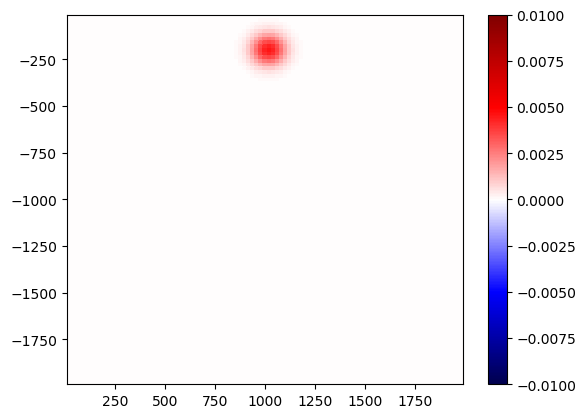

In [27]:
PyPlot.pcolormesh(g.xC, g.zC, rotr90(R.T[end, :, 1, :]) .- 283, vmin=-0.01, vmax=0.01, cmap="seismic"); PyPlot.colorbar();

In [28]:
anim = @animate for tidx in 1:Int(Nt/ΔR)
    Plots.heatmap(g.xC, g.zC, rotl90(R.T[tidx, :, 1, :]) .- 283, color=:balance,
        clims=(-0.01, 0.01),
        # clims=(-maximum(R.T[tidx, :, 1, :] .- 283), maximum(R.T[tidx, :, 1, :] .- 283)),
        title="T change @ t=$(tidx*ΔR*Δt)")
end
mp4(anim, "tracer_$(round(Int, time())).mp4", fps = 60)

┌ Info: Saved animation to 
│   fn = D:\Home\Git\Oceananigans.jl\tracer_1544812403.mp4
└ @ Plots C:\Users\Ali\.julia\packages\Plots\y6yik\src\animation.jl:90


Plots.AnimatedGif("D:\\Home\\Git\\Oceananigans.jl\\tracer_1544812403.mp4")